# HIP application walkthrough - Matrix Multiplication

Often it is helpful to see a complete example that is fully explained in every detail. Matrix multiplication is a commonly employed compute operation. There are many math problems in STEM that can be reduced to a matrix multiplication. We use it for a complete example with HIP. The  multiplication of matrices **A** and **B** proceeds by taking the dot product between every row **i0** in matrix **A** and every column **i1** of matrix **B**. If we multiply (elementwise) a row (at index **i0**) of matrix **A** with a column (at index **i1**) of Matrix B, then the dot product is the sum of the multiplied elements. The result of each dot product is then the value at position (i0,i1) in matrix **C**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C.</figcaption>
</figure>


The strategy we use here is to associate a kernel with every point (m,n) in Matrix C. This means the Grid for this problem must be large enough to cover the entire size of Matrix C. Every kernel will compute its own dot product and place the result in Matrix C. The source code for the example is in [mat_mult.cpp](mat_mult.cpp). Click on the link and open up the file in a different window.

## Running the example program

Let's run the application and see the results, then we can understand how it works.

### Write out the matrices

The first step is to generate some matrices **A** and **B** for use by the program. We use a Python class called **MatMul** in <a href="../include/py_helper.py">py_helper.py</a> to make up matrices **A** and **B** and write those matrices to binary files **array_A.dat** and **array_B.dat**. We just use binary storage (storing raw floats to disk) for the elements of the array. It is not self-describing or architecture indepedent, but just for teaching purposes it does provide a well-supported way to cross the gap between Python and C++.

In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

# Load the size of the matrix from file
NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.make_data()

### Compile and run the program

The makefile is set to compile the example.

In [2]:
!make clean; make; ./mat_serial.exe

rm -r *.exe
hipcc -g -O2 -fopenmp -I/usr/include -I../include -L/usr/lib/x86_64-linux-gnu mat_mult.cpp\
	-o mat_mult.exe 
hipcc -g -O2 -fopenmp -I/usr/include -I../include -L/usr/lib/x86_64-linux-gnu mat_serial.cpp\
	-o mat_serial.exe 


### Read in the answer and verify results

The **check_data** function in the **MatMul** class (see <a href="../include/py_helper.py">py_helper.py</a>) just reads the binary file **array_C.dat** from disk and compares it to matrix C that was generated in Python during the call to **make_data**.

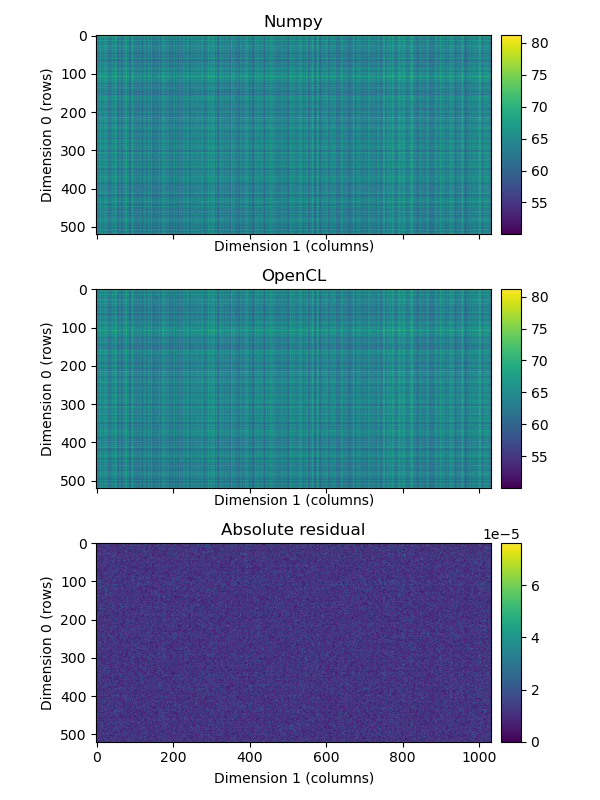

In [4]:
mat_mul.check_data()

## The example program - line by line

As covered in the Introduction, during runtime every accelerated application in HIP follows the same logical progression of steps: 

1. Compute resources discovered
1. Memory allocated on compute device/s
1. Memory is copied from the host to the compute device/s
1. Kernels run on the compute device/s
1. Wait for the kernels to finish
1. Memory is copied back from the compute device/s to the host
1. Repeat steps 3 - 6 as many times as necessary
1. Clean up resources and exit

For the matrix multiplication problem with OpenCL we have chosen the following strategy:

1. Parse program arguments
1. Discover resources and choose a compute device
1. Read in matrices **A** and **B** from file into host memory
1. Allocate memory for arrays **A**, **B**, and **C** on the compute device
1. Upload matrices **A** and **B** from the host to the corresponding memory allocations on the device
1. Run the kernel to compute **C** from **A** and **B**
1. Copy the buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. Clean up memory alllocations and release resources

We now walk through every line of the source file [mat_mult.cpp](mat_mult.cpp) and explain how everything is working in as much depth as is practical. With HIP there is some boilerplate code and some best practices to be followed. In the following examples we have encapsulated both using helper functions. Each helper function starts with **h_** and is defined in the header file <a href="../include/hip_helper.hpp">hip_helper.hpp</a>. It is helpful to have both the source code of the main program [mat_mult.cpp](mat_mult.cpp) and the helper header <a href="../include/hip_helper.hpp">hip_helper.hpp</a> open while we traverse the code.

### Headers

We begin with some essential includes and include a file [mat_size.hpp](mat_size.hpp) that defines the size of the arrays being computed. 

```C++
// mat_mult.cpp

// Setup headers
#include <cassert>
#include <cmath>
#include <iostream>

// Bring in the size of the matrices
#include "mat_size.hpp"
```
Then we include the helper headers "hip_helper.hpp" to bring in a set of functions that reduce some of the tedious tasks of setting up resources.

```C++
// Bring in helper header to manage boilerplate code
#include "hip_helper.hpp"
```

In this instance the header **hip_helper.hpp** is located in the **course_material/include** directory. Open the file by clicking on this link to <a href="../include/hip_helper.hpp">hip_helper.hpp</a>. 

### Step 1. Parse command line arguments

In a heterogeneous compute environment there may be more than one HIP device to choose from. We would like to be able to use command line arguments to select what devices are used. HIP just uses integers to select compute devices, and the  **h_parse_args** function parses command line arguments to fetch from the command line a device index.

```C++
// mat_mult.cpp source

// Parse arguments and set the target device
int dev_index = h_parse_args(argc, argv);
```

The optional arguments we support are:

* \<id\>; a number for the index of the device
* **-h**, **--help**; print a help message and exit

By default we use device index 0.

#### Example usage with command line arguments

In [3]:
# Using the CPU at device index 0
!./mat_mult.exe 0

Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)


In [4]:
# Calling the help
!./mat_mult.exe -h

Usage: ./mat_mult.exe <options> <DEVICE_INDEX>
Options:
	-h,--help	 print help message
	DEVICE_INDEX is a number > 0


Every example program in the course that parses arguments in this way will have these options.

### Sanity checking HIP function calls

Every call to a HIP function has some way of checking wether or not it worked. This information is returned in the form of an error code. The data type **hipError_t** stores the error code. There are a number of values that a variable of type **hipError_t** can store, **hipSuccess** means that the function call was successful. For error codes that contain other values we can use the function **hipGetErrorString** to extract the helpful error string that is associated with the error code. The following macro, defined as **H_ERRCHK** in <a href="../include/hip_helper.hpp">hip_helper.hpp</a> can parse the value in **hipError_t** and extract a useful help message as well as the file and line number that the error was generated in.

```C++
// hip_helper.hpp source

#define H_ERRCHK(cmd) \
{\
    hipError_t errcode = cmd; \
    if (errcode != hipSuccess) { \
        const char* errstring = hipGetErrorString(errcode); \
        std::fprintf( \
            stderr, \
            "Error, HIP call failed at file %s, line %d\n Error string is: %s\n", \
            __FILE__, __LINE__, errstring \
        ); \
        exit(EXIT_FAILURE); \
    }\
}
```

#### Example usage

The HIP function **hipInit** is used to explicitly initialise the HIP runtime. It returns a value of type **hipError_t**. We can use the **H_ERRCHK** macro to examine the output of **hipInit** in the following way:


```C++
// mat_mult.cpp source

H_ERRCHK(hipInit(0));
```

The macro will intercept the value from the output of the function and examine it to see if the function call returns **hipSuccess**. Otherwise it will crash the program with a useful error message.

### Step 2. Resource discovery

1. Parse program arguments
1. **Discover resources and choose a compute device**
1. Read in matrices **A** and **B** from file into host memory
1. Allocate memory for arrays **A**, **B**, and **C** on the compute device
1. Upload matrices **A** and **B** from the host to the corresponding memory allocations on the device
1. Run the kernel to compute **C** from **A** and **B**
1. Copy the buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. Clean up memory alllocations and release resources

From the <a href="../L1_Introduction/Intro.ipynb">Introduction</a> we saw that device buffers are allocated within resource managers called **contexts**. When handling multiple devices it **used to be good practice** to create at least one context for every device and for threads to "push" a context when needed, and "pop" the context afterwards. This created a lot of context management overhead and programmer headaches. 

<figure style="margin-left:auto; margin-right:auto; width:50%;">
    <img style="vertical-
                align:middle" src="../images/hip_components.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Picking  platforms, discovering devices, and creating contexts.</figcaption>
</figure>

Now the HIP api makes sure a primary context is available for a thread whenever a thread executes a hip function, and you can choose which device to use with **hipSetDevice**. We can ensure a primary context is available for all devices by cycling through the devices at the start of program runtime and making sure the primary contexts are initialised and clean. We use the helper function **h_acquire_devices** to initialise each compute device and context. 

```C++
    // mat_mult.cpp source

    h_acquire_devices(&num_devices, dev_index);
```

#### Examining **h_acquire_devices** in depth

We now examine the function **h_acquire_devices**, whose source code is in <a href="../include/hip_helper.hpp">hip_helper.hpp</a>. 

```C++
// Function to simply acquire devices
void h_acquire_devices(int* num_devices, int default_device_id) {
    // Initialise HIP 
    h_errchk(hipInit(0));

    // Get the number of devices
    h_errchk(hipGetDeviceCount(num_devices));

    // Check to make sure we have one or more suitable devices
    if (*num_devices <= 0) {
        std::printf("Failed to find a suitable compute device\n");
        exit(EXIT_FAILURE);
    }

    // Make sure the default device id is sane
    assert ((default_device_id<*num_devices) && (default_device_id>=0));

    // Clean and reset devices
    h_reset_devices(*num_devices);

    // Set the device
    h_errchk(hipSetDevice(default_device_id));
}
```

At runtime a call to a HIP API function will initialise HIP and make sure a primary context exists on compute device 0. It is good practice to explicitly initialise HIP though, and we use the **hipInit** function to do this. Next, we check the number of available devices with **hipGetDeviceCount** and assert that we have at least one device. Then we call the helper function **h_reset_devices** to reset the available compute devices and make sure everything is clean.

```C++
// Function to reset devices before and after runtime
void h_reset_devices(int num_devices) {
    
    // Reset devices
    for (int i = 0; i<num_devices; i++) {
        // Set device
        h_errchk(hipSetDevice(i));

        // Synchronize device 
        h_errchk(hipDeviceSynchronize());

        // Reset device (destroys primary context)
        h_errchk(hipDeviceReset());
        
        // Set the device to reinitialise the device
        h_errchk(hipSetDevice(i));
    }
}
```

The function loops through the number of available compute devices and chooses the compute device to use with **hipSetDevice**. With this call a primary context is made available, if not already initialised, and that context is "bound" to the host thread that called it. Any host thread may call **hipSetDevice** at any time to set the compute device and associate the devices primary context with the calling thread. The function **hipDeviceSynchronize** ensures that everything using the context has finishes, and the function **hipDeviceReset** destroys the primary context and releases all resources that were previously used on the device. A followup call to **hipSetDevice** then re-initialises the primary context. Now the primary context on each compute device has been refreshed and we can be certain that all contexts available to the program are in a clean state.

#### Compute device selection

Returning the the **h_acquire_devices** function, after the call to **h_reset_devices**, we use **hipSetDevice** to set the compute device to **default_device_id**.

```C++
    // hip_helper.hpp source 

    // Set the device
    h_errchk(hipSetDevice(default_device_id));
```

#### Fetch compute device capabilities

All acclerator devices have resource limits, such as the number of threads that can exist in a block, or the maximum size of a shared memory allocation. Sometimes it is necessary to explore these limits. Returning to the next line of text in [mat_mult.cpp](mat_mult.cpp) we call a helper function **h_report_on_device** to explore these limits and print a report on our chosen device at device index **dev_index**.

```C++
    // mat_mult.cpp source

    // Report on the device in use
    h_report_on_device(dev_index);
```

This will show us the following information:

* Name of the device
* Global memory size
* Available number of 32-bit registers
* Maximum shared memory size per block
* Maximum block size
* Maximum Grid size

#### Examining **h_report_on_device** in depth

Below is the code for the function **h_report_on_device**. Given a device id the function uses a call to **hipGetDeviceProperties** to fill a structure of type **hipDeviceProp_t** with the properties of the compute device. Then we use dot notation to access the elements of the structure and report back.

```C++
// hip_helper.hpp source

// Function to report information on a compute device
void h_report_on_device(int device_id) {

    // Report some information on a compute device
    hipDeviceProp_t prop;

    // Get the properties of the compute device
    h_errchk(hipGetDeviceProperties(&prop, device_id));

    // ID of the compute device
    std::printf("Device id: %d\n", device_id);

    // Name of the compute device
    std::printf("\t%-40s %s\n","name:", prop.name);

    // Size of global memory
    std::printf("\t%-40s %lu MB\n","global memory size:",prop.totalGlobalMem/(1000000));

    // Maximum number of registers per block
    std::printf("\t%-40s %d \n","available registers per block:",prop.regsPerBlock);

    // Maximum shared memory size per block
    std::printf("\t%-40s %lu KB\n","maximum shared memory size per block:",prop.sharedMemPerBlock/(1000));

    // Maximum pitch size for memory copies (MB)
    std::printf("\t%-40s %lu MB\n","maximum pitch size for memory copies:",prop.memPitch/(1000000));

    // Print out the maximum number of threads along a dimension of a block
    std::printf("\t%-40s (", "max block size:");
    for (int n=0; n<2; n++) {
        std::printf("%d,", prop.maxThreadsDim[n]);
    }
    std::printf("%d)\n", prop.maxThreadsDim[2]); 
    std::printf("\t%-40s %d\n", "max threads in a block:", prop.maxThreadsPerBlock);
    
    // Print out the maximum size of a Grid
    std::printf("\t%-40s (", "max Grid size:");
    for (int n=0; n<2; n++) {
        std::printf("%d,", prop.maxGridSize[n]);
    }
    std::printf("%d)\n", prop.maxGridSize[2]); 
}

```

### Step 3. Reading matrices from disk

1. Parse program arguments
1. Discover resources and choose a compute device
1. **Read in matrices **A** and **B** from file into host memory**
1. Allocate memory for arrays **A**, **B**, and **C** on the compute device
1. Upload matrices **A** and **B** from the host to the corresponding memory allocations on the device
1. Run the kernel to compute **C** from **A** and **B**
1. Copy the buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. Clean up memory alllocations and release resources

This isn't a HIP task, but we need the matrices **A** and **B** read into memory before creating device Buffers. A helper function called **h_read_binary** is employed to open a binary file, determine file size, create a memory allocation and read the contents of the file directly into it.

```C++
    // mat_mult.cpp source

    size_t N1_A = NCOLS_A, N0_C = NROWS_C, N1_C = NCOLS_C;
    size_t nbytes_A, nbytes_B, nbytes_C;

    //// Step 3. Read matrices A and B from file into host memory ////
    
    float* A_h = (float*)h_read_binary("array_A.dat", &nbytes_A);
    float* B_h = (float*)h_read_binary("array_B.dat", &nbytes_B);

    // Sanity check on incoming data
    assert(nbytes_A==N0_C*N1_A*sizeof(float));   
    assert(nbytes_B==N1_A*N1_C*sizeof(float));
    nbytes_C=N0_C*N1_C*sizeof(float);
```

> Notice that the memory allocations are labelled **A_h**, and **B_h**. The **_h** suffix in the name of the allocation is just *naming convention* to highlight that the memory is allocated on the host.

If we look at the source code for **h_read_binary** in <a href="../include/hip_helper.hpp">hip_helper.hpp</a>, the **fseek**, **ftell**, and **rewind**, functions are used to determine the size of the file before using **fread** to read the file into a memory allocation. Of course there are better ways to do this with C++ iostreams, but the techniques used here also work in C with minimal translation.

```C++
// hip_helper.hpp source

void* h_read_binary(const char* filename, size_t *nbytes) {
    // Open the file for reading and use std::fread to read in the file
    std::FILE *fp = std::fopen(filename, "rb");
    if (fp == NULL) {
        std::printf("Error in reading file %s", filename);
        exit(EXIT_FAILURE);
    }
    
    // Seek to the end of the file
    std::fseek(fp, 0, SEEK_END);
    
    // Extract the number of bytes in this file
    *nbytes = std::ftell(fp);

    // Rewind the file pointer
    std::rewind(fp);
```
In the event that the file being read is a string we add an extra termination character at the end of the allocation. We use the helper function **h_alloc** to allocate aligned memory to receive the context of the file. Alternatively the HIP function **hipHostMalloc** can be used to allocate page-locked memory on the host (memory that cannot be paged out to disk). Page locked memory enables the fastest memory transfers between host and compute device, however page-locked allocations will impact the OS if they get too large.

```C++
    // Create a buffer to read into
    // Add an extra Byte for a null termination character
    // just in case we are reading to a string
    void *buffer = h_alloc((*nbytes)+1, BYTE_ALIGNMENT);
    
    // Set the NULL termination character for safety
    char* source = (char*)buffer;
    source[*nbytes] = '\0';
    
    // Read the file into the buffer and close
    size_t bytes_read = std::fread(buffer, 1, *nbytes, fp);
    assert(bytes_read == *nbytes);
    std::fclose(fp);
    return buffer;
}
```

### Step 4. Allocate memory for arrays A, B, and C on the compute device

1. Parse program arguments
1. Discover resources and choose a compute device
1. Read in matrices **A** and **B** from file into host memory
1. **Allocate memory for arrays **A**, **B**, and **C** on the compute device**
1. Upload matrices **A** and **B** from the host to the corresponding memory allocations on the device
1. Run the kernel to compute **C** from **A** and **B**
1. Copy the buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. Clean up memory alllocations and release resources

After choosing a compute device we now have a primary context through which we can manage allocations of memory on the compute device (buffers). The HIP function **hipMalloc** is used to allocate buffers, as shown below:

```C++
    // mat_mult.cpp source

    //// Step 4. Allocate on-device memory for matrices A, B, and C ////
    float *A_d, *B_d, *C_d;
    H_ERRCHK(hipMalloc((void**)&A_d, nbytes_A));
    H_ERRCHK(hipMalloc((void**)&B_d, nbytes_B));
    H_ERRCHK(hipMalloc((void**)&C_d, nbytes_C));
```

> Note that we use the **_d** suffix (i.e A_d) for variable names to indicate that the memory allocation is on the device. This is just programming convention that might be helpful.

When we are done with this memory it is **best practice** to use the **hipFree** command to release the memory allocation on the compute device and free up resources. See these lines from the end of the program.

```C++
    // mat_mult.cpp source

    // Free the HIP buffers
    H_ERRCHK(hipFree(A_d));
    H_ERRCHK(hipFree(B_d));
    H_ERRCHK(hipFree(C_d));
```

### Step 5. Upload matrices A and B from the host to the corresponding memory allocations on the device

The **hipMemcpy** function is a way to transfer memory between host and device. Here we use the function as follows:

```C++
    // mat_mult.cpp source

    // to the HIP device allocations ////
    H_ERRCHK(hipMemcpy(A_d, A_h, nbytes_A, hipMemcpyHostToDevice));
    H_ERRCHK(hipMemcpy(B_d, B_h, nbytes_B, hipMemcpyHostToDevice));
```

The first argument is always the destination pointer, and the second argument is the source. The last flag is to tell **hipMemcpy** what kind of copy to perform. Available flags are:

* hipMemcpyHostToHost
* hipMemcpyHostToDevice
* hipMemcpyDeviceToHost
* hipMemcpyDeviceToDevice
* hipMemcpyDefault

The last flag (hipMemcpyDefault) is to have the runtime determine what kind of copy we are doing based on what memory the pointers are pointing to.


### Step 6. Run the kernel to compute C from A and B

1. Parse program arguments
1. Discover resources and choose a compute device
1. Read in matrices **A** and **B** from file into host memory
1. Allocate memory for arrays **A**, **B**, and **C** on the compute device
1. Upload matrices **A** and **B** from the host to the corresponding memory allocations on the device
1. **Run the kernel to compute C from A and B**
1. Copy the buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. Clean up memory alllocations and release resources

During compilation of a program the HIP compiler separates out kernel code from host code. The host code is compiled to machine code and the kernel code is compiled to an intermediate representation. When a kernel is run the corresponding intermediate kernel code is JIT (just in time) compiled and cached just before execution on the device. This strategy means two things:

* The kernel source can be part of the source file
* The first run of a kernel can be slower than subsequent runs due to JIT compilation overheads.

#### Kernel source code

The kernel for matrix multiplication computes a single value in matrix **C** at coordinates (i0, i1) by computing the dot product between row **i0** of matrix **A** with column **i1** of matrix **B**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C.</figcaption>
</figure>

The function **mat_mult** in [mat_mult.cpp](mat_mult.cpp) is the kernel source, and it is in the same file as the program.

```C++
// standard matrix multiply kernel 
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
} 
```

#### Kernel preamble

The definition of our kernel is as follows:

```C++
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) {
```
Qualifiers help the compiler decide what to do with code blocks. The qualifier **\_\_global\_\_** at the beginning signifies that the function is a kernel that is executed on the compute device. Additional qualifiers that can be specified in the preamble are **\_\_device\_\_** which signifies that the function runs on the device and may be called by either a **kernel** or another function that runs on the device. Finally the extra qualifier **\_\_host\_\_** means the function may also be called from the host. 

| Qualifier     | Purpose |
| ----------- | ----------- |
| \_\_global\_\_  | Specify that the function is a kernel to be run on the device |
| \_\_device\_\_ | Specify that a function is to be run on the device and called from a kernel or other device functioin |
| \_\_host\_\_ | Specify that a function is to be run on the host |

Qualifiers can be used in tandem, for example both **\_\_host\_\_** and **\_\_device\_\_** can be used together to specify a function that can run on both the host and the device!

#### Arguments

All kernels must have return type **void**. Arguments to the kernel are copied to the device **by value** when the kernel is called, and the number of arguments in the kernel must equal the number of arguments passed in. Device memory allocations are passed into the kernel using the pointer to that allocation, and within the kernel the memory is accessed using array indexing (e.g A[0]). Memory may not be allocated dynamically within the kernel, so memory allocations on the device must be performed beforehand from the host.

#### Location within the grid

From the <a href="../L1_Introduction/L1 - Introduction.ipynb">Introduction</a> we know that a 3D grid (or iteration space) is specified at kernel launch, and that kernels execute within blocks, and blocks make up the grid. 

<figure style="margin-left:auto; margin-right:auto; width:70%;">
    <img style="vertical-align:middle" src="../images/grid.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Three-dimensional Grid with work-items and work-groups.</figcaption>
</figure>

Within the kernel we have the following pre-defined structures that can help us determine where we are within the grid.

| Structure      | Purpose |
| ----------- | ----------- |
| gridDim.{xyz}  | How many blocks are along a dimension of the grid |
| blockDim.{xyz} | How many threads are along a dimension of a block |
| blockIdx.{xyz} | Index of the block along a dimension of the grid (0-based) |
| threadIdx.{xyz} | Index of the thread along a dimension of the block (0-based) |

The **x** dimension (dimension 0) is generally the fastest (contiguous) dimension within a block. That dimension should be aligned with the fastest dimension in your memory allocation. In this example we are using row major ordering for our matrices where dimension 1 is contiguous, therefore dimension **x** of the Grid must be aligned with the dimension 1 of the matrices. We map the grid coordinates (x,y) to matrix coordinates (i0,i1) using the mapping:

```C++
    // mat_mult.cpp source

    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
```

#### Guard clause

Now that we know the location of the thread (i0, i1) within matrix C we proceed to iterate along row **i0** of matrix A, and down column **i1** of matrix B. Since an integer number of blocks must fit within the grid, it is possible that the grid is larger than matrix C. Therefore we use a guard clause to make sure we don't run off the end of the arrays.
```C++
    // mat_mult.cpp source

    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

#### Kernel execution

The next step in the process is to execute the kernel. The macro **hipLaunchKernelGGL** is the recommended way to launch HIP kernels, it needs as input the number of blocks along each dimension of the grid, and the number of threads along each dimension of the block - in addition to kernel arguments. Choosing the right block size is important for performance. Since kernels are executed lock-step in **teams of 64 wavefronts** it is best for performance if the number of threads in a block is a multiple of 64 but less than the maximum permissible number of threads in a block. The HIP structure **dim3** stores this information, and we use the helper function **h_fit_blocks** to construct the number of blocks given a desired grid size (global_size) and a chosen block size. We use a block size of (8,8,1) for this example because it is a multiple of 64.

```C++
 // Desired block size
    dim3 block_size = { 8, 8, 1 };
    dim3 global_size = { (uint32_t)N1_C, (uint32_t)N0_C, 1 };
    dim3 grid_nblocks;
    
    // Choose the number of blocks so that Grid fits within it.
    h_fit_blocks(&grid_nblocks, global_size, block_size);
```

Now we can (finally!) run the kernel. The **hipLaunchKernelGGL** macro is a C/C++ compliant way to run kernels.

```C++
    // Launch the kernel using hipLaunchKernelGGL method
    // Amount of shared memory to use in the kernel
    size_t sharedMemBytes=0;
    
    // Launch the kernel using hipLaunchKernelGGL method
    hipLaunchKernelGGL(mat_mult, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            N1_A,
            N0_C,
            N1_C
    );
```

The first five parameters are part of the kernel launch: 

* kernel_name (mat_mult)
* number of blocks along each dimension of the grid (grid_nblocks)
* number of threads along each dimension of a block (block_size)
* number of bytes to allocate for shared memory (sharedMemBytes)
* Stream to use (0 is the null or default stream).

> Note: A stream is a queue where work (such as kernels and copies) is submitted. HIP has the ability to perform work concurrently using multiple streams. The default stream (stream 0) is the stream we use when we aren't trying to perform concurrent operations. Streams and concurrent operations are a topic for the more advanced modules.

The next 6 parameters (A_d...) are for the kernel itself. Kernel launches are asynchronous in the sense that the **hipLaunchKernelGGL** function returns immmediately. 

> Note: We could have used the CUDA triple chevron syntax to launch kernels

```C++
    mat_mult<<<grid_nblocks, block_size, 0, 0>>>(A_d, B_d, C_d, N1_A, N0_C, N1_C);
```

Now the kernel is queued to the default stream, we explicitly wait for it to finish using the command:

```C++
    // Wait for any commands to complete on the compute device
    H_ERRCHK(hipDeviceSynchronize());
```



### Step 7. Copy the buffer for matrix **C** back to the host

Once we have finished the kernel we can now copy the memory from matrix C back to the host.

```C++
    //// Step 7. Copy the Buffer for matrix C back to the host ////
    H_ERRCHK(hipMemcpy(C_h, C_d, nbytes_C, hipMemcpyDeviceToHost));
```

Memory copies using **hipMemcpy** are synchronous, that means the call above will block until the copy is complete. Since the copy is using the same stream as the kernel above, the null stream, then the copy will be queued right after the kernel function. This means that the copy would have waited for the kernel anyway, and we didn't have to use the **hipDeviceSynchronize** function. There is also a sister asynchronous copy function called **hipMemcpyAsync** which will not block if the host memory is pinned (or allocated with **hipHostMalloc**).

### Writing the results to disk

Now we use a helper function **h_write_binary** from <a href="../include/hip_helper.hpp">hip_helper.hpp</a> to write out the contents of array_C to disk.

```C++
    // Write out the result to file
    h_write_binary(array_C, "array_C.dat", nbytes_C);
```

If we look at the source of **h_write_binary** we just use the standard library functions **fopen**, **fwrite**, and **fclose** to write a data allocation to disk. 

```C++
// hip_helper.hpp source

void h_write_binary(void* data, const char* filename, size_t nbytes) {
    // Write binary data to file
    std::FILE *fp = std::fopen(filename, "wb");
    if (fp == NULL) {
        std::printf("Error in writing file %s", filename);
        exit(OCL_EXIT);
    }
    
    // Write the data to file
    std::fwrite(data, nbytes, 1, fp);
    
    // Close the file
    std::fclose(fp);
}
```

### Cleaning up resources

1. Parse program arguments
1. Discover resources and choose a compute device
1. Read in matrices **A** and **B** from file into host memory
1. Allocate memory for arrays **A**, **B**, and **C** on the compute device
1. Upload matrices **A** and **B** from the host to the corresponding memory allocations on the device
1. Run the kernel to compute **C** from **A** and **B**
1. Copy the buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. **Clean up memory alllocations and release resources**

During resource cleanup it is good practice to free all memory allocations on the host and the devices, and then to reset the devices (refresh the primary contexts). Some profiling tools work best if the devices are reset at the end of execution. We first use **hipFree** to free memory allocations on the compute device.

```C++
    // mat_mult.cpp source

    // Free the HIP buffers
    H_ERRCHK(hipFree(A_d));
    H_ERRCHK(hipFree(B_d));
    H_ERRCHK(hipFree(C_d));
```
Now we can free the host arrays using the C function **free**.

```C++
    // Clean up memory that was allocated on the read   
    free(A_h);
    free(B_h);
    free(C_h);
```
Now we use the helper function **h_reset_devices** to iterate through all compute devices and call the **hipDeviceReset** function to destory the primary contexts.
```C++
    // mat_mult.cpp

    // Reset compute devices
    h_reset_devices(num_devices);
```

## Summary
With this program we have explored in depth a majority of the machinery used in HIP applications. It provides a base to explore further topics such as profiling and optimisation, error checking and debugging, and managing streams with events.

<!---
Table of the commonly used OpenCL functions used in this program can be found in the **<a href="../Reference_notes/OpenCL_function_tables.ipynb">OpenCL function tables</a>** notebook in the reference notes directory. In addition, a table of helper functions used in <a href="../include/hip_helper.hpp">hip_helper.hpp</a> is located in **<a href="../Reference_notes/Helper_function_table.ipynb">Helper function table</a>**.
-->

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the Pawsey Supercomputing Centre
</address>